# Smiles Detection

In [1]:
import os
import cv2
import imutils
import numpy as np
import pandas as pd
from tqdm import tqdm
from imutils import paths
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from keras import backend as K
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model
from keras.preprocessing.image import img_to_array
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Flatten, Activation, Dropout

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

## Data 

[SMILEsmileD](https://github.com/hromi/SMILEsmileD)

In [3]:
data = []
labels = []

imagepaths = list(paths.list_images('/media/karolis/TOSHIBA/DL4CV/SB_Code/SB_Code/datasets/SMILEsmileD'))

with tqdm(total=len(imagepaths)) as pbar:
    for imagepath in imagepaths:
        img = cv2.imread(imagepath)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = imutils.resize(gray, width=28)
        gray = img_to_array(gray)
        data.append(gray)
        
        label = imagepath.split(os.path.sep)[-3]
        
        # 1 - smiling, 0 - not smiling
        labels.append(label == 'positives')
        
        pbar.update(1)

100%|██████████| 13165/13165 [00:39<00:00, 334.17it/s]


In [4]:
data = np.array(data, dtype=float) / 255.0
labels = np.array(labels, dtype=int)

In [5]:
label_encoder = LabelEncoder().fit(labels)
labels = np_utils.to_categorical(label_encoder.transform(labels), 2)

In [6]:
X_training, X_test, Y_training, Y_test = train_test_split(
    data,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

The distribution of positive (smiles) and negative examples is uneven. The label imbalance can be corrected by computing a weight for each class. 

In [7]:
weights = Y_training.sum(axis=0).max() / Y_training.sum(axis=0) 

## Model

### Training

In [8]:
classes = 2
epochs = 100
batch_size = 32
height, width, depth = 28, 28, 1
input_shape = (height, width, depth)

if K.image_data_format() == 'channels_first':
    input_shape = (depth, height, width)

model = Sequential()
    
model.add(Conv2D(
    32, 
    (5, 5),
    padding="same",
    input_shape=input_shape
))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(
    64,
    (5, 5),
    padding="same"
))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(
    64,
    (5, 5),
    padding="same"
))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(
    32,
    (5, 5),
    padding="same"
))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(Activation("softmax"))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

checkpointer = ModelCheckpoint(
    monitor='val_acc',
    filepath='model.h5', 
    verbose=1, 
    save_best_only=True
)

history = model.fit(
    X_training,
    Y_training,
    validation_data=(X_test, Y_test),
    class_weight=weights,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[checkpointer]
)

Train on 10532 samples, validate on 2633 samples
Epoch 1/100
10532/10532 [==============================] - 15s 1ms/step - loss: 0.5880 - acc: 0.7201 - val_loss: 0.4479 - val_acc: 0.7717

Epoch 00001: val_acc improved from -inf to 0.77174, saving model to model.h5
Epoch 2/100
10532/10532 [==============================] - 2s 166us/step - loss: 0.4393 - acc: 0.7961 - val_loss: 0.3343 - val_acc: 0.8675

Epoch 00002: val_acc improved from 0.77174 to 0.86745, saving model to model.h5
Epoch 3/100
10532/10532 [==============================] - 2s 166us/step - loss: 0.3845 - acc: 0.8298 - val_loss: 0.3073 - val_acc: 0.8716

Epoch 00003: val_acc improved from 0.86745 to 0.87163, saving model to model.h5
Epoch 4/100
10532/10532 [==============================] - 2s 166us/step - loss: 0.3553 - acc: 0.8449 - val_loss: 0.3076 - val_acc: 0.8845

Epoch 00004: val_acc improved from 0.87163 to 0.88454, saving model to model.h5
Epoch 5/100
10532/10532 [==============================] - 2s 169us/step - 

10532/10532 [==============================] - 2s 167us/step - loss: 0.2662 - acc: 0.8943 - val_loss: 0.2562 - val_acc: 0.9009

Epoch 00042: val_acc did not improve from 0.90695
Epoch 43/100
10532/10532 [==============================] - 2s 178us/step - loss: 0.2661 - acc: 0.8918 - val_loss: 0.2314 - val_acc: 0.9062

Epoch 00043: val_acc did not improve from 0.90695
Epoch 44/100
10532/10532 [==============================] - 2s 175us/step - loss: 0.2589 - acc: 0.8937 - val_loss: 0.2336 - val_acc: 0.9047

Epoch 00044: val_acc did not improve from 0.90695
Epoch 45/100
10532/10532 [==============================] - 2s 175us/step - loss: 0.2565 - acc: 0.8984 - val_loss: 0.2354 - val_acc: 0.9088

Epoch 00045: val_acc improved from 0.90695 to 0.90885, saving model to model.h5
Epoch 46/100
10532/10532 [==============================] - 2s 168us/step - loss: 0.2631 - acc: 0.8932 - val_loss: 0.2455 - val_acc: 0.9054

Epoch 00046: val_acc did not improve from 0.90885
Epoch 47/100
10532/10532 [==

10532/10532 [==============================] - 2s 169us/step - loss: 0.2312 - acc: 0.9104 - val_loss: 0.2266 - val_acc: 0.9085

Epoch 00084: val_acc did not improve from 0.91075
Epoch 85/100
10532/10532 [==============================] - 2s 169us/step - loss: 0.2381 - acc: 0.9045 - val_loss: 0.2276 - val_acc: 0.9157

Epoch 00085: val_acc improved from 0.91075 to 0.91569, saving model to model.h5
Epoch 86/100
10532/10532 [==============================] - 2s 170us/step - loss: 0.2361 - acc: 0.9059 - val_loss: 0.2288 - val_acc: 0.9088

Epoch 00086: val_acc did not improve from 0.91569
Epoch 87/100
10532/10532 [==============================] - 2s 170us/step - loss: 0.2397 - acc: 0.9055 - val_loss: 0.2345 - val_acc: 0.9062

Epoch 00087: val_acc did not improve from 0.91569
Epoch 88/100
10532/10532 [==============================] - 2s 171us/step - loss: 0.2330 - acc: 0.9065 - val_loss: 0.2282 - val_acc: 0.9073

Epoch 00088: val_acc did not improve from 0.91569
Epoch 89/100
10532/10532 [==

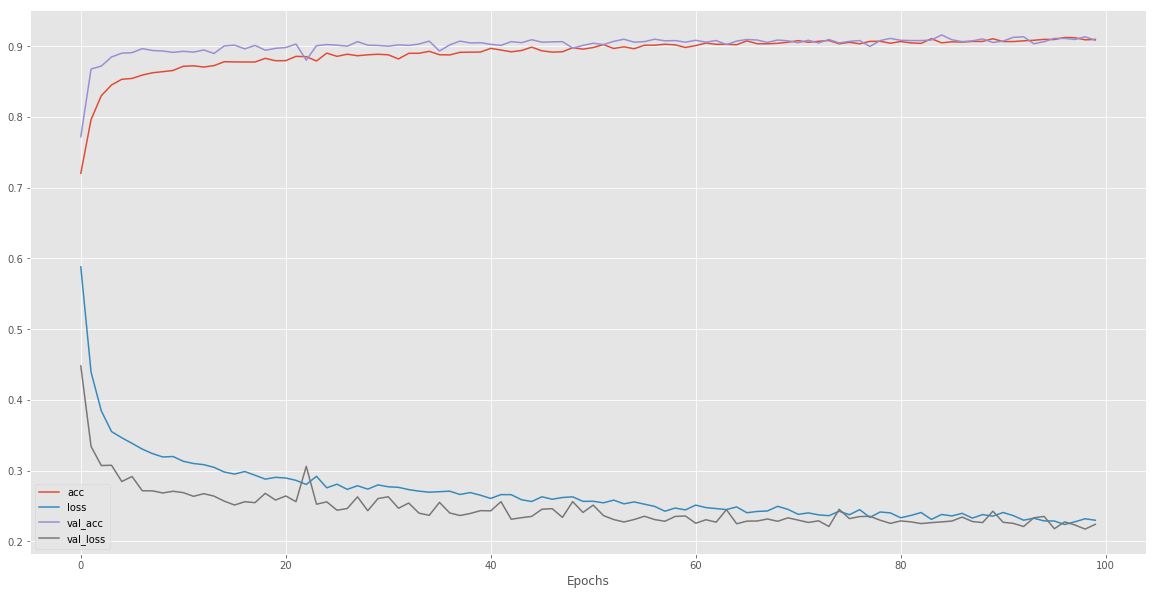

In [9]:
plt.style.use('ggplot')
pd.DataFrame(history.history).plot(figsize=(20, 10), markersize=14)
plt.xlabel('Epochs')
plt.show();

### Test

In [10]:
model = load_model('model.h5')
predictions = model.predict(X_test, batch_size=64)

print(classification_report(
    Y_test.argmax(axis=1),
    predictions.argmax(axis=1),
))

             precision    recall  f1-score   support

          0       0.92      0.96      0.94      1895
          1       0.90      0.79      0.84       738

avg / total       0.91      0.92      0.91      2633

